# Introduction

## Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) are used to generate images that never existed before. They learn about the world (objects, animals, and more) and create new versions of those images.

### Components of GANs:

1. **Generator**: This creates the images.
2. **Discriminator**: This assesses the images and tells the generator if they are similar to what it has been trained on. These are based on real-world examples.

During training, both the generator and discriminator start from scratch and learn together.

---

## How GANs Work

- **G** for *Generative*: This model takes a random noise signal as input and outputs an image.
  
- **A** for *Adversarial*: This refers to the discriminator, which acts as the opponent to the generator. The discriminator learns about objects, animals, or other features provided. For example, if you train it with images of dogs and non-dogs, it will be able to distinguish between the two.

  - If you present an image that isn’t a dog, the discriminator will return a 0.
  - If you present a dog image, it will return a 1.

- **N** for *Network*: Both the generator and discriminator are neural networks.

---

## GANs Process

### Step 1:

1. Input a random noise signal into the **generator**.
2. The generator creates some images, which are then used to train the **discriminator**.
3. The discriminator is provided with some real images (features) to learn from, and it outputs probabilities, which can be initially high since it has just started training.
4. The error is calculated, backpropagated, and the discriminator's weights are updated.

Next, we train the generator:

1. The generated images are passed through the discriminator again, without including the real images.
2. The generator learns by "tricking" the discriminator into outputting false positives.
3. The error is calculated, backpropagated, and the generator's weights are updated.

### Step 2:

This step is similar to Step 1, but now both the generator and discriminator are a little more trained. Through backpropagation, the generator starts to understand its mistakes and gradually creates images that resemble the real-world features.

The generator achieves this through a **Deconvolutional Neural Network**.

---

## Examples of GANs Applications:

- Generating Images
- Image Modification
- Super Resolution
- Assisting Artists
- Photo-Realistic Images
- Speech Generation
- Face Aging


In [3]:
# lets see get the data and important modules

In [9]:
import os

print(os.listdir("./data/GAN/input/"))

['all-dogs']


In [11]:
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

There are 20579 pictures of dogs.


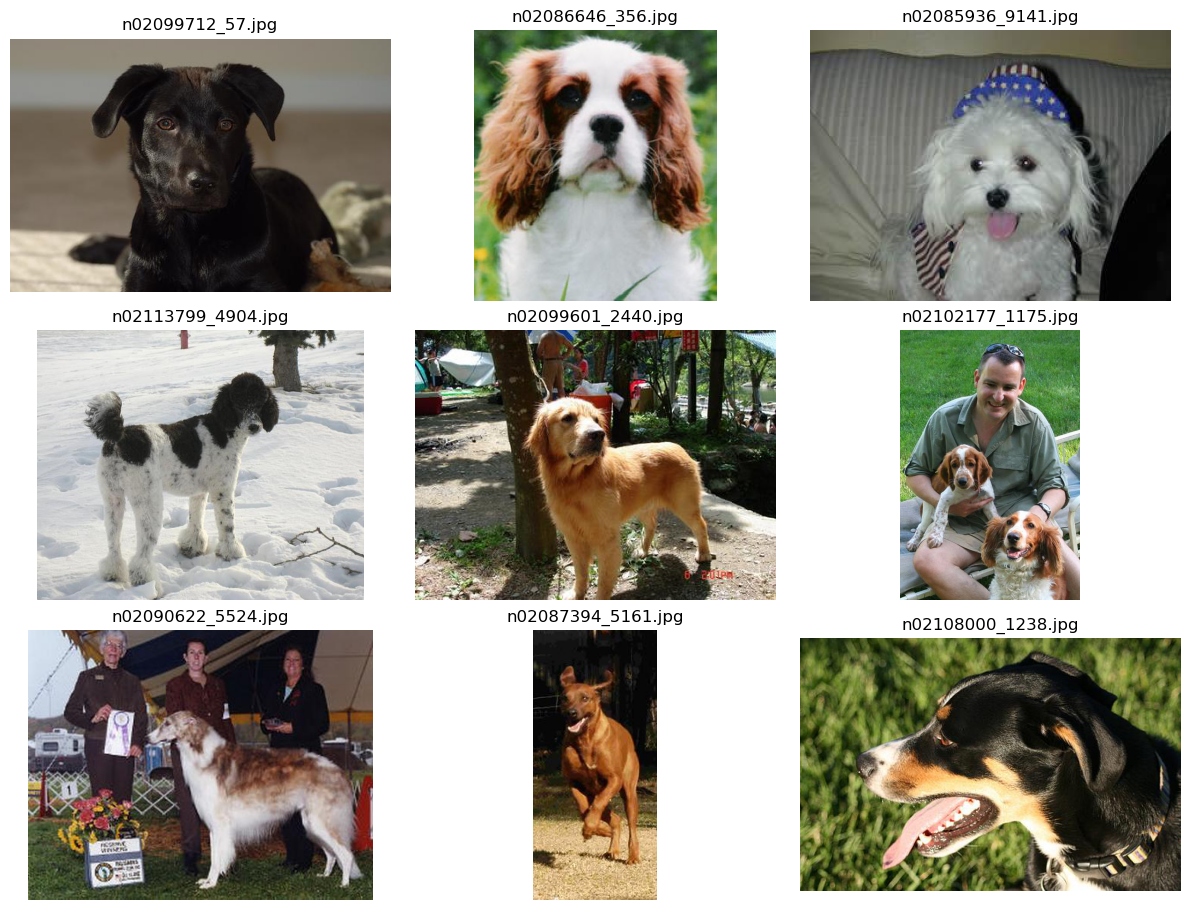

In [15]:
PATH = './data/GAN/input/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(os.listdir(PATH))} pictures of dogs.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread(PATH + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Image preprocessing


### Setting Batch and Image Sizes

- `batch_size = 32`: Defines the batch size for the dataloader, which means the model will process 32 images at a time during training.
- `imageSize = 64`: Defines the size of the images. Each image will be resized to 64x64 pixels.

### Data Transformation Pipeline

```python
transform = transforms.Compose([
    transforms.Resize(64),  # Resizes the input image to 64x64 pixels.
    transforms.CenterCrop(64),  # Crops the center part of the image to 64x64 pixels.
    transforms.ToTensor(),  # Converts the image to a PyTorch tensor with values between 0 and 1.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes the tensor values to a range of [-1, 1].
])
```

### DataLoader: Loads the dataset and prepares it for training

- `train_data`: The dataset of images.
- `shuffle=True`: Ensures the data is shuffled before each epoch, improving training.
- `batch_size=batch_size`: The number of images processed in one batch (32 here).

### Fetching a Batch of Images

- `next(iter(dataloader))`: Fetches the next batch of images and their corresponding labels.
- `imgs`: The batch of images (in tensor format).
- `label`: The corresponding labels for the images.

### Image Transformation for Visualization

- `imgs.numpy()`: Converts the image tensor from PyTorch to a NumPy array, which is often required for visualization.
- `transpose(0, 2, 3, 1)`: Rearranges the axes of the image from PyTorch format (batch, channels, height, width) to a format suitable for visualization (batch, height, width, channels).

In [24]:
batch_size = 32
imageSize = 64

# 64x64
transform = transforms.Compose([transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('./data/GAN/input/', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [102]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('./data/GAN/input/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [34]:
# lets have alook at the resulted images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


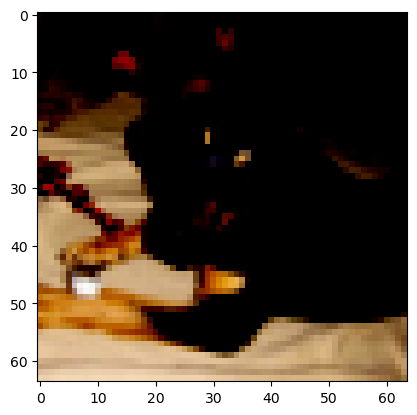

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


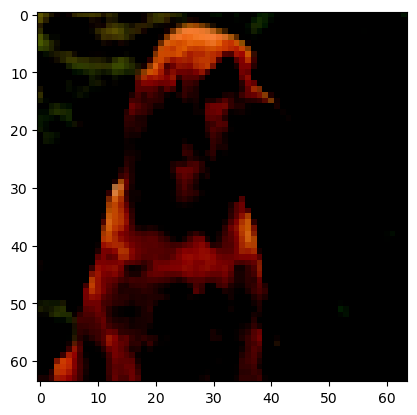

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


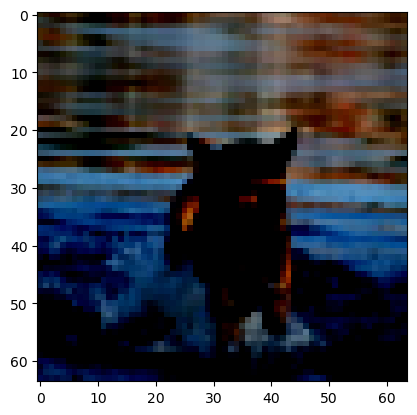

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


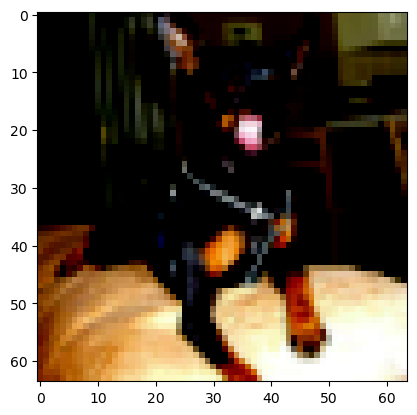

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


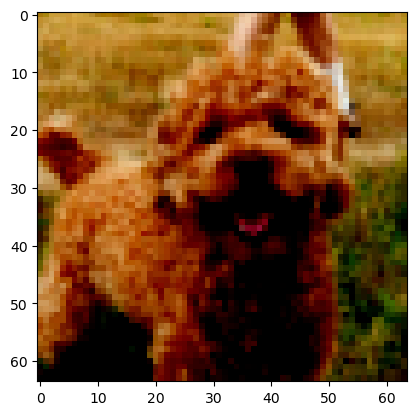

In [36]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

## Weight function

### Purpose:

The `weights_init(m)` function initializes the weights of the neural network model, `m`. It is typically used when training models to ensure that the weights are set with appropriate initial values before the training begins. This is particularly important for Convolutional layers (Conv layers) and Batch Normalization layers (BatchNorm layers) in deep learning models.

```python
classname = m.__class__.__name__  # Retrieves the name of the class for each layer in the network.
if classname.find('Conv') != -1:  # Checks if the layer is a convolutional layer.
    m.weight.data.normal_(0.0, 0.02)  # Initializes the weights of the Conv layer using a normal distribution with mean=0 and std=0.02.
elif classname.find('BatchNorm') != -1:  # Checks if the layer is a batch normalization layer.
    m.weight.data.normal_(1.0, 0.02)  # Initializes the weights of the BatchNorm layer using a normal distribution with mean=1 and std=0.02.
    m.bias.data.fill_(0)  # Initializes the bias of the BatchNorm layer to 0.
```

In [38]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

### Purpose:

The class `G` defines a **Generator** neural network model using PyTorch's `nn.Module`. This is typically used in a Generative Adversarial Network (GAN) to generate images by taking in random noise as input and transforming it through a series of transposed convolutional layers into an image.

### Code Breakdown:

#### `__init__` Method:

```python
def __init__(self):
    super(G, self).__init__()  # Calls the parent class (nn.Module) constructor to properly initialize the module 
    self.main = nn.Sequential  # Defines the main architecture of the generator using nn.Sequential, which is a container to stack layers.
    
```

In [50]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

In [52]:
netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Discriminator

### Purpose:

The class `D` defines a **Discriminator** neural network model using PyTorch's `nn.Module`. This is typically used in a Generative Adversarial Network (GAN) to classify whether an input image is real or fake. The discriminator learns to distinguish real images from those generated by the generator.

- `nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False)` Standard 2D convolutional layer with  3 (for RGB images) input channels and 64 output channels
- `nn.LeakyReLU(negative_slope=0.2, inplace=True)`  activation function with a negative slope of 0.2, allowing a small gradient for negative values to prevent dead neurons.

- `forward(self, input)` Defines the forward pass for the discriminator. The input image is passed through the layers defined in self.main.
- `output.view(-1)`: This flattens the 2D output to a 1D tensor, which represents the probability that the input image is real.

In [64]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        # .view(-1) = Flattens the output into 1D instead of 2D
        return output.view(-1)


In [66]:
netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [92]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

# Training

In [75]:
EPOCH = 0 # play with me
LR = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [77]:
for epoch in range(EPOCH):
    for i, data in enumerate(dataloader, 0):
        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        # 2nd Step: Updating the weights of the neural network of the generator
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

In [88]:
batch_size = 32
LR_G = 0.001
LR_D = 0.0005

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [96]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

In [100]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

C:\Users\druzh\AppData\Local\Temp\ipykernel_17472\3139552926.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/644 [00:00<?, ?it/s]

[1/100][322/644] Loss_D: 1.2476 Loss_G: 1.0842 D(x): 0.5122 D(G(z)): 0.4174 / 0.3231
[1/100][644/644] Loss_D: 1.0487 Loss_G: 2.8680 D(x): 0.6449 D(G(z)): 0.3930 / 0.0774


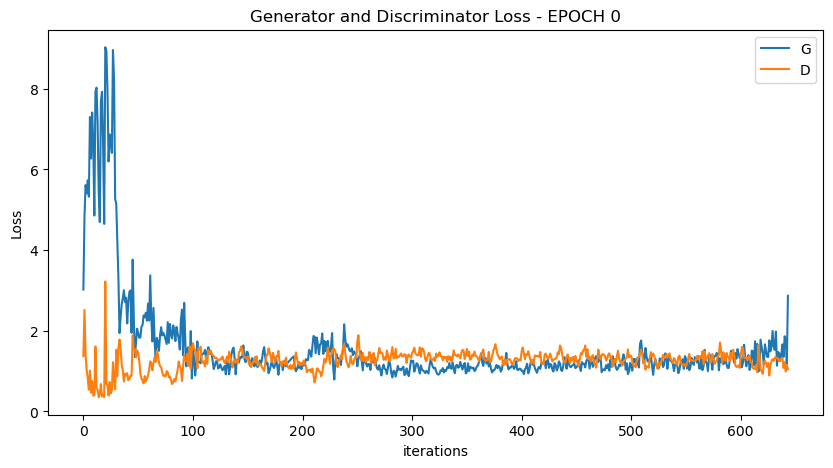

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


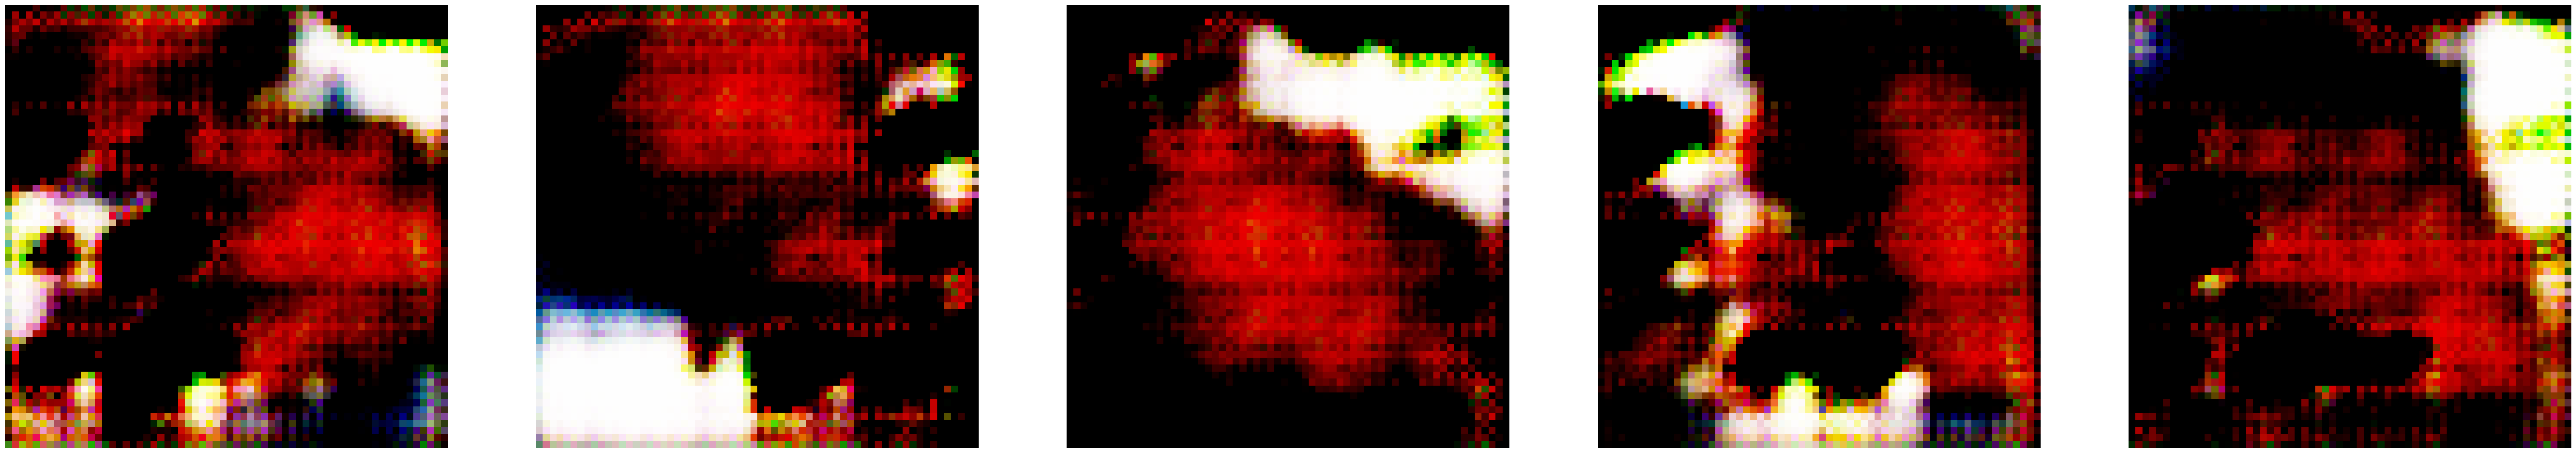

  0%|          | 0/644 [00:00<?, ?it/s]

[2/100][322/644] Loss_D: 1.0710 Loss_G: 1.4179 D(x): 0.4761 D(G(z)): 0.2485 / 0.2296
[2/100][644/644] Loss_D: 1.6038 Loss_G: 1.9994 D(x): 0.3734 D(G(z)): 0.4773 / 0.1170


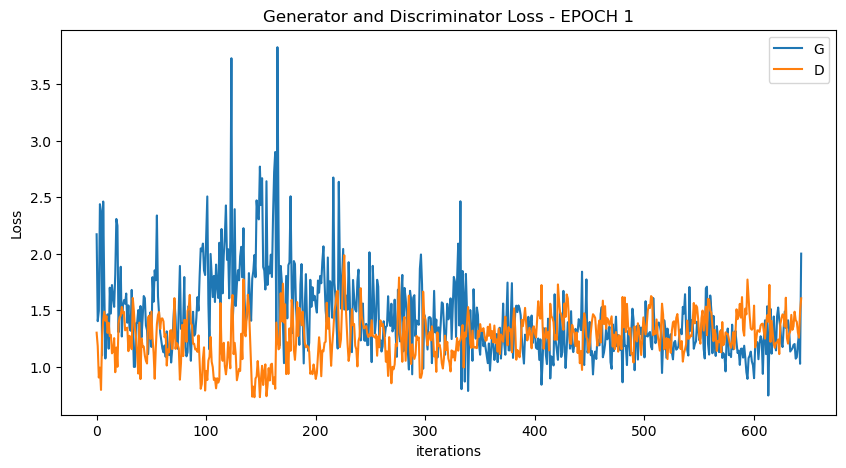

  0%|          | 0/644 [00:00<?, ?it/s]

[3/100][322/644] Loss_D: 1.3946 Loss_G: 0.9498 D(x): 0.4099 D(G(z)): 0.3645 / 0.3936
[3/100][644/644] Loss_D: 1.7307 Loss_G: 1.1145 D(x): 0.2437 D(G(z)): 0.3346 / 0.3145


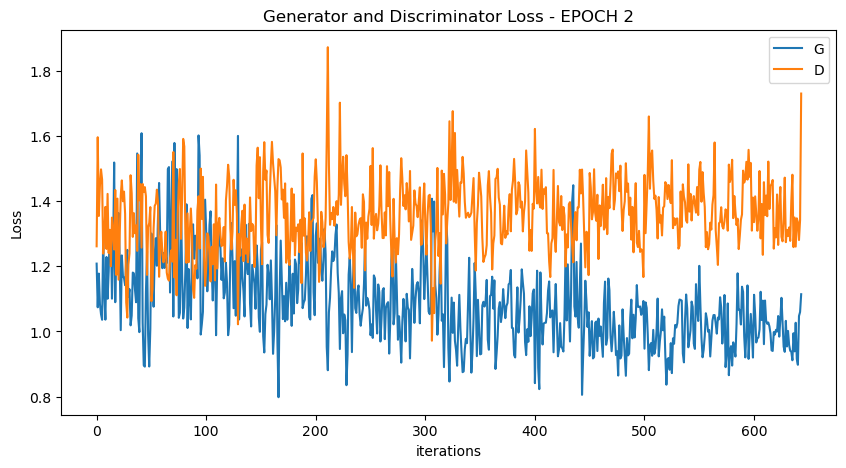

  0%|          | 0/644 [00:00<?, ?it/s]

[4/100][322/644] Loss_D: 1.3730 Loss_G: 1.0591 D(x): 0.5470 D(G(z)): 0.5031 / 0.3382
[4/100][644/644] Loss_D: 0.8697 Loss_G: 1.9575 D(x): 0.6866 D(G(z)): 0.3111 / 0.1174


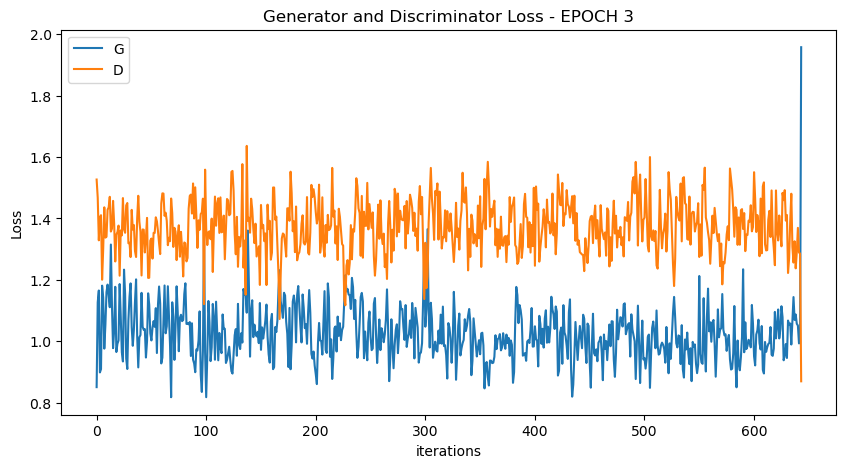

  0%|          | 0/644 [00:00<?, ?it/s]

[5/100][322/644] Loss_D: 1.5104 Loss_G: 1.0749 D(x): 0.3877 D(G(z)): 0.4197 / 0.3302
[5/100][644/644] Loss_D: 1.4625 Loss_G: 2.0893 D(x): 0.5010 D(G(z)): 0.5090 / 0.1047


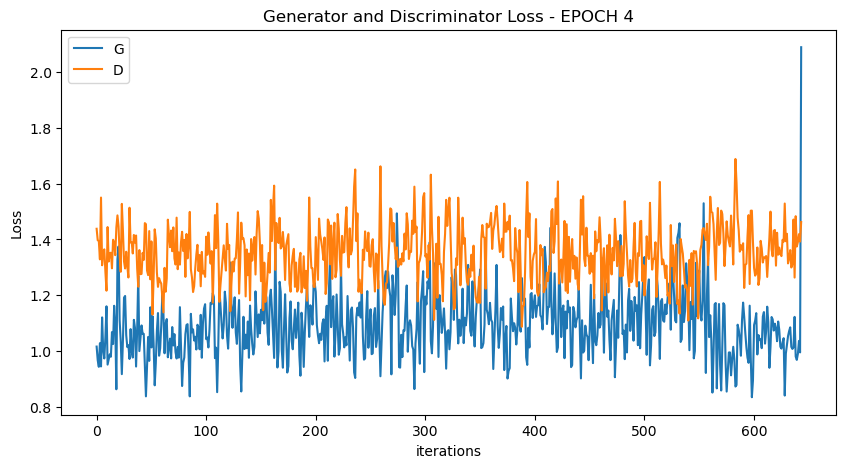

  0%|          | 0/644 [00:00<?, ?it/s]

[6/100][322/644] Loss_D: 1.3620 Loss_G: 1.0735 D(x): 0.5310 D(G(z)): 0.4881 / 0.3295
[6/100][644/644] Loss_D: 1.2055 Loss_G: 2.1744 D(x): 0.5264 D(G(z)): 0.3967 / 0.0921


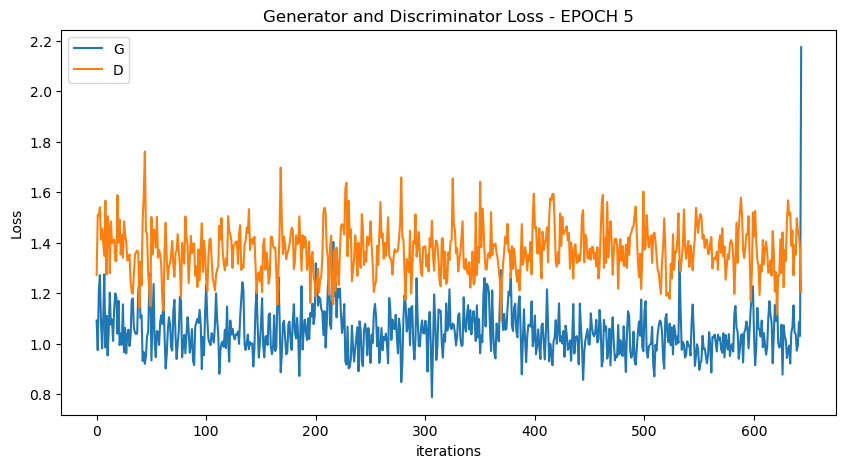

  0%|          | 0/644 [00:00<?, ?it/s]

[7/100][322/644] Loss_D: 1.2485 Loss_G: 1.1377 D(x): 0.5591 D(G(z)): 0.4436 / 0.3086
[7/100][644/644] Loss_D: 1.2199 Loss_G: 1.5687 D(x): 0.4268 D(G(z)): 0.2954 / 0.1840


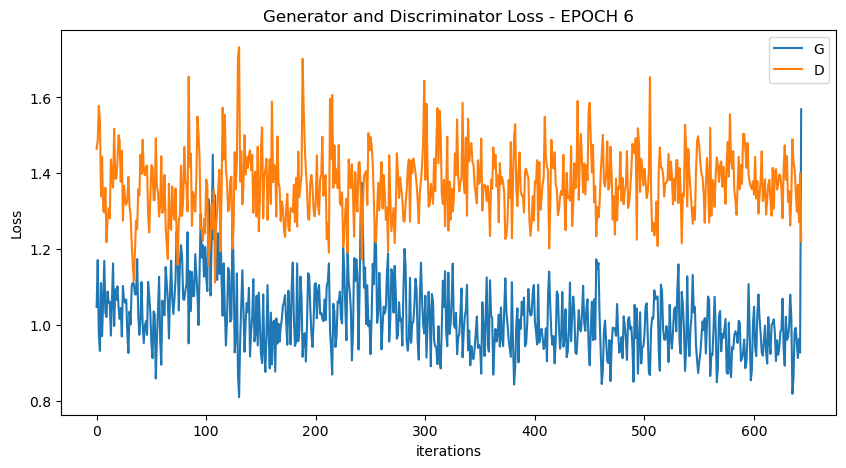

  0%|          | 0/644 [00:00<?, ?it/s]

[8/100][322/644] Loss_D: 1.3923 Loss_G: 0.9592 D(x): 0.5101 D(G(z)): 0.4853 / 0.3764
[8/100][644/644] Loss_D: 1.8634 Loss_G: 0.9900 D(x): 0.2196 D(G(z)): 0.3537 / 0.3693


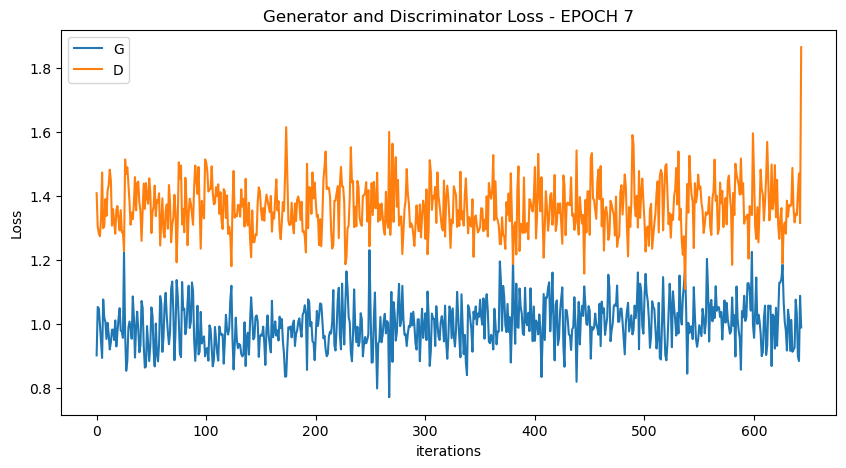

  0%|          | 0/644 [00:00<?, ?it/s]

[9/100][322/644] Loss_D: 1.3768 Loss_G: 0.9622 D(x): 0.4813 D(G(z)): 0.4531 / 0.3741
[9/100][644/644] Loss_D: 1.3844 Loss_G: 1.6595 D(x): 0.3972 D(G(z)): 0.3491 / 0.1625


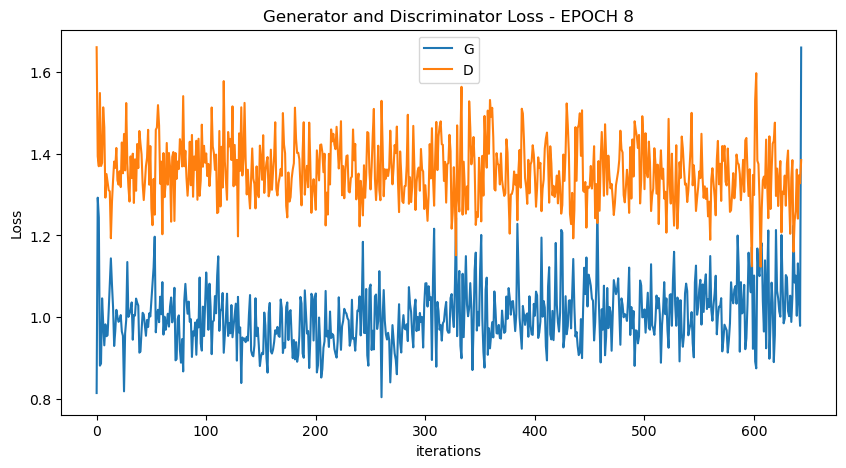

  0%|          | 0/644 [00:00<?, ?it/s]

[10/100][322/644] Loss_D: 1.3373 Loss_G: 1.0724 D(x): 0.5034 D(G(z)): 0.4545 / 0.3268
[10/100][644/644] Loss_D: 1.5684 Loss_G: 1.6855 D(x): 0.3879 D(G(z)): 0.4457 / 0.1695


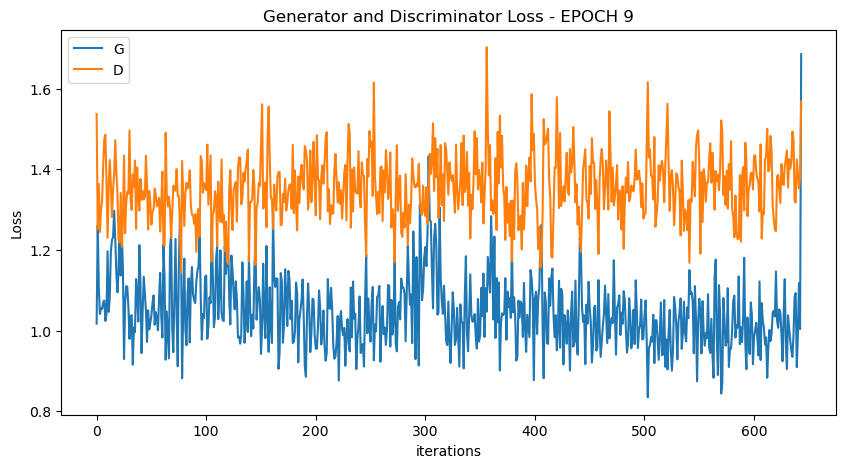

  0%|          | 0/644 [00:00<?, ?it/s]

[11/100][322/644] Loss_D: 1.5530 Loss_G: 0.8439 D(x): 0.4215 D(G(z)): 0.4914 / 0.4265
[11/100][644/644] Loss_D: 1.1987 Loss_G: 1.4310 D(x): 0.4579 D(G(z)): 0.2846 / 0.2698


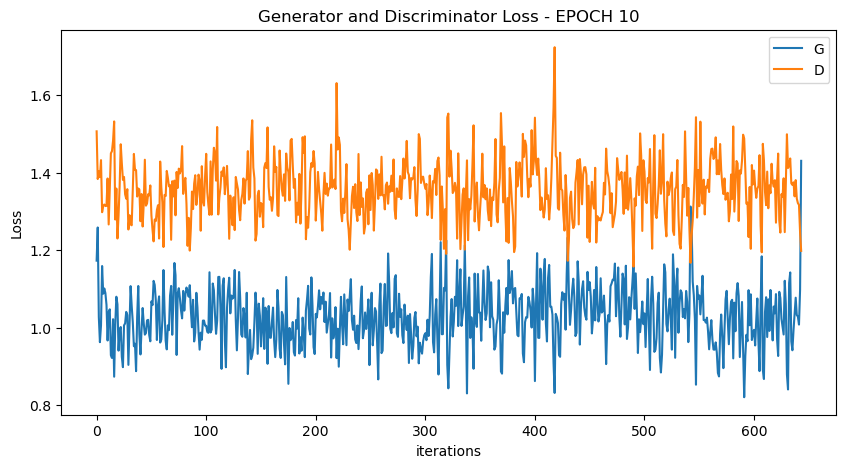

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


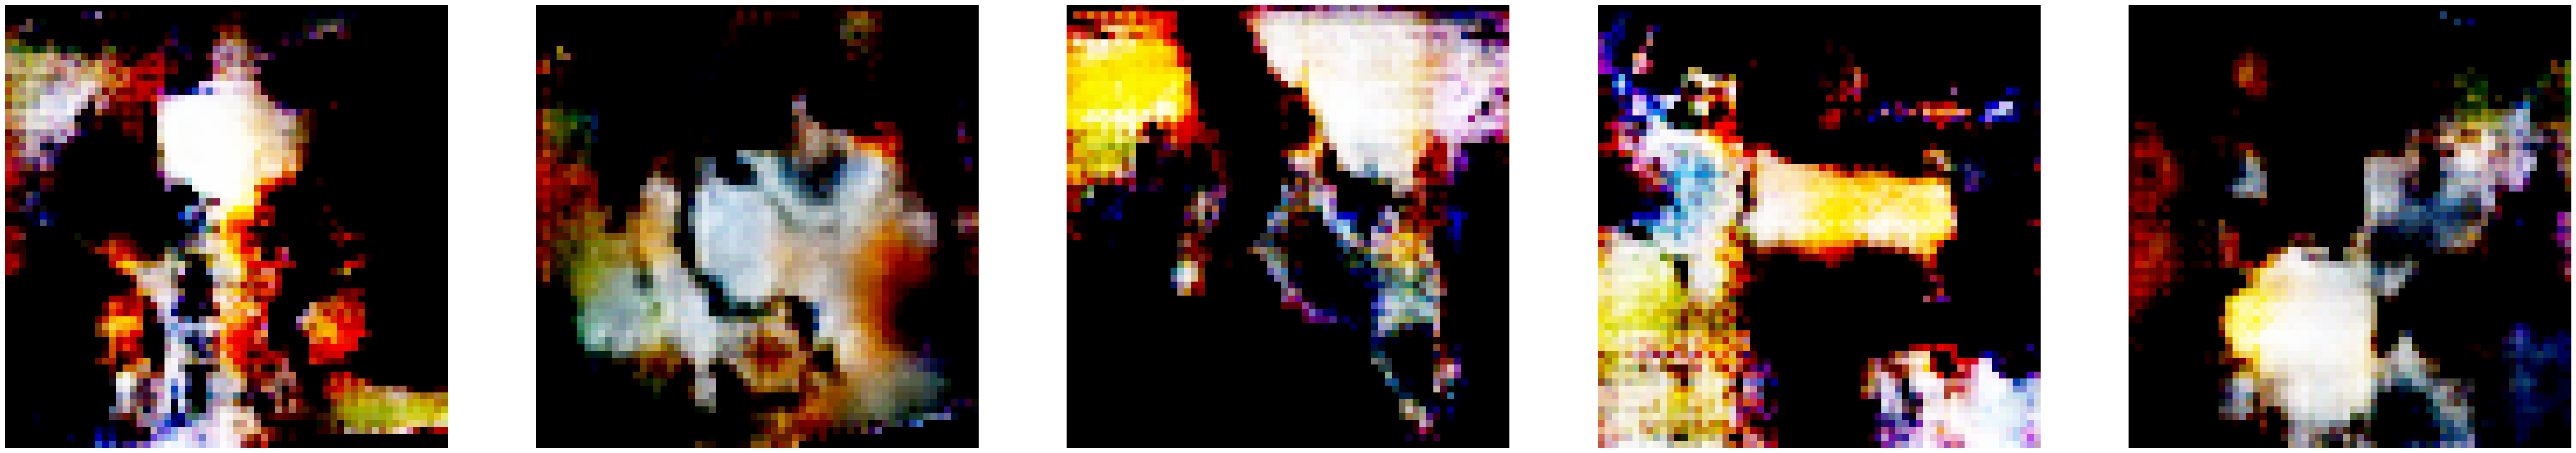

  0%|          | 0/644 [00:00<?, ?it/s]

[12/100][322/644] Loss_D: 1.4003 Loss_G: 0.9594 D(x): 0.4208 D(G(z)): 0.4110 / 0.3708
[12/100][644/644] Loss_D: 1.6592 Loss_G: 1.5661 D(x): 0.3052 D(G(z)): 0.4104 / 0.1803


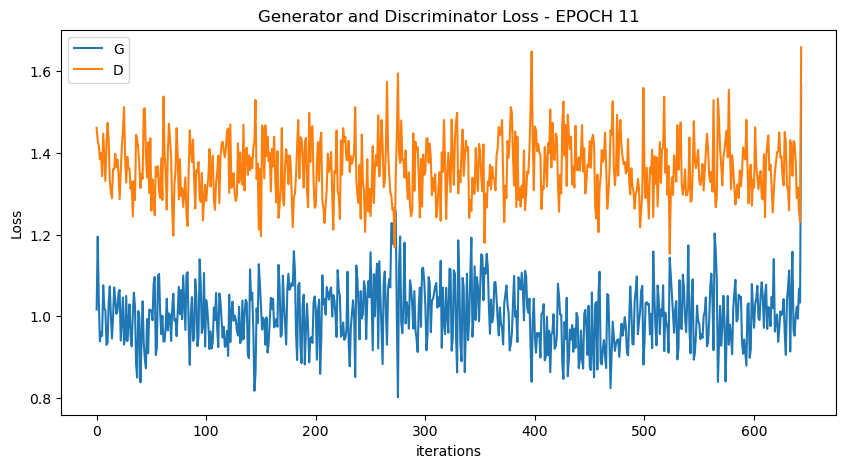

  0%|          | 0/644 [00:00<?, ?it/s]

[13/100][322/644] Loss_D: 1.4386 Loss_G: 0.9069 D(x): 0.4426 D(G(z)): 0.4536 / 0.3903
[13/100][644/644] Loss_D: 1.5364 Loss_G: 1.3986 D(x): 0.3209 D(G(z)): 0.3713 / 0.2222


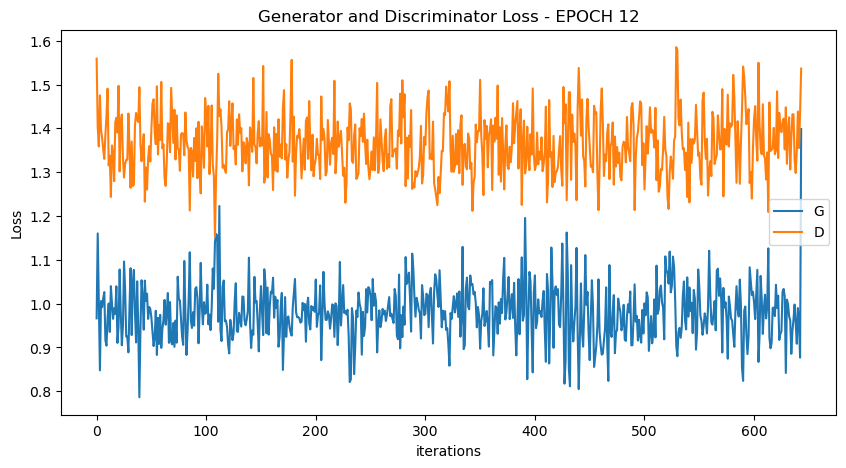

  0%|          | 0/644 [00:00<?, ?it/s]

[14/100][322/644] Loss_D: 1.3198 Loss_G: 1.0409 D(x): 0.4732 D(G(z)): 0.4185 / 0.3380
[14/100][644/644] Loss_D: 1.1041 Loss_G: 1.7325 D(x): 0.5094 D(G(z)): 0.3429 / 0.1522


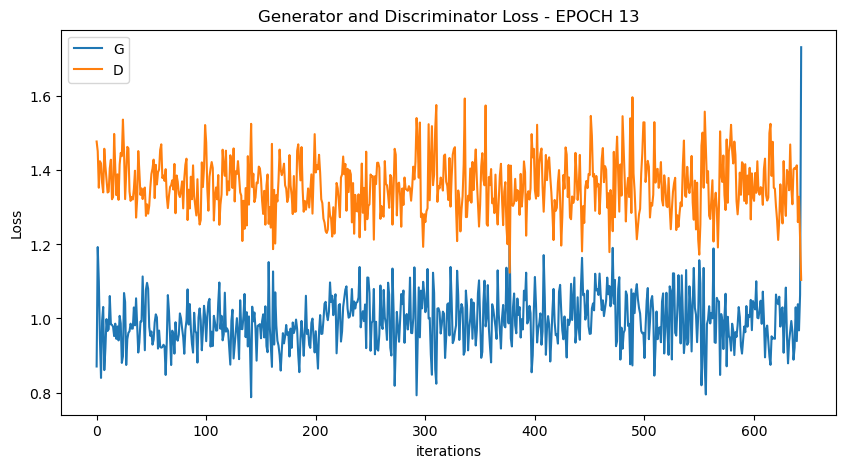

  0%|          | 0/644 [00:00<?, ?it/s]

[15/100][322/644] Loss_D: 1.3610 Loss_G: 0.8861 D(x): 0.4551 D(G(z)): 0.4274 / 0.4067
[15/100][644/644] Loss_D: 1.1728 Loss_G: 1.5950 D(x): 0.4906 D(G(z)): 0.3566 / 0.1765


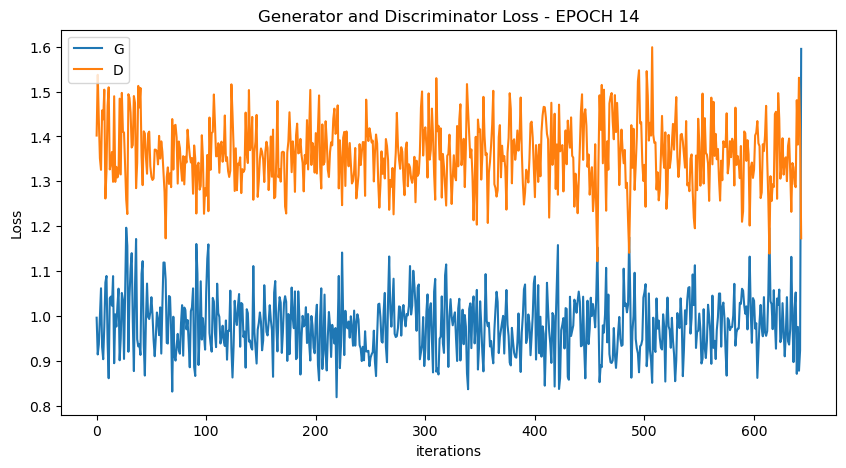

  0%|          | 0/644 [00:00<?, ?it/s]

[16/100][322/644] Loss_D: 1.2589 Loss_G: 1.0031 D(x): 0.4682 D(G(z)): 0.3826 / 0.3542
[16/100][644/644] Loss_D: 1.4026 Loss_G: 1.5292 D(x): 0.4297 D(G(z)): 0.4179 / 0.1935


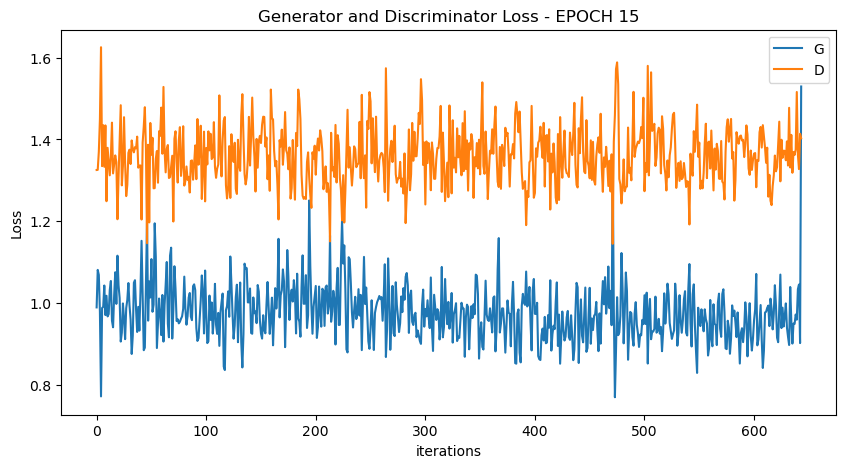

  0%|          | 0/644 [00:00<?, ?it/s]

[17/100][322/644] Loss_D: 1.3787 Loss_G: 0.9701 D(x): 0.4183 D(G(z)): 0.3902 / 0.3683
[17/100][644/644] Loss_D: 1.5753 Loss_G: 1.3987 D(x): 0.3102 D(G(z)): 0.3652 / 0.2319


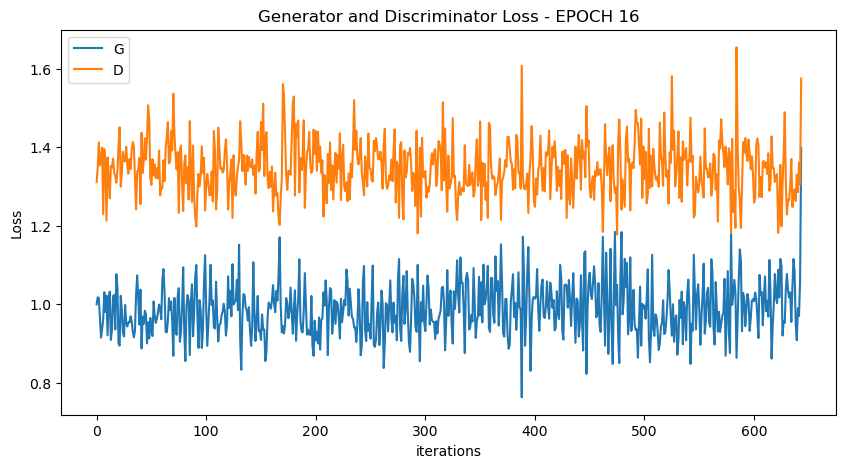

  0%|          | 0/644 [00:00<?, ?it/s]

[18/100][322/644] Loss_D: 1.4970 Loss_G: 0.8975 D(x): 0.4046 D(G(z)): 0.4386 / 0.4038
[18/100][644/644] Loss_D: 1.1871 Loss_G: 2.0170 D(x): 0.5171 D(G(z)): 0.3867 / 0.1121


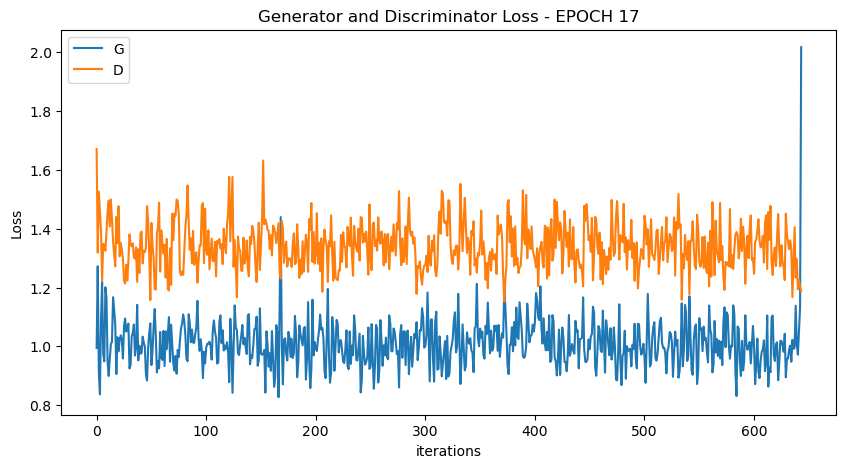

  0%|          | 0/644 [00:00<?, ?it/s]

[19/100][322/644] Loss_D: 1.3245 Loss_G: 0.9659 D(x): 0.3845 D(G(z)): 0.3141 / 0.3704
[19/100][644/644] Loss_D: 1.1934 Loss_G: 2.0751 D(x): 0.4927 D(G(z)): 0.3783 / 0.1265


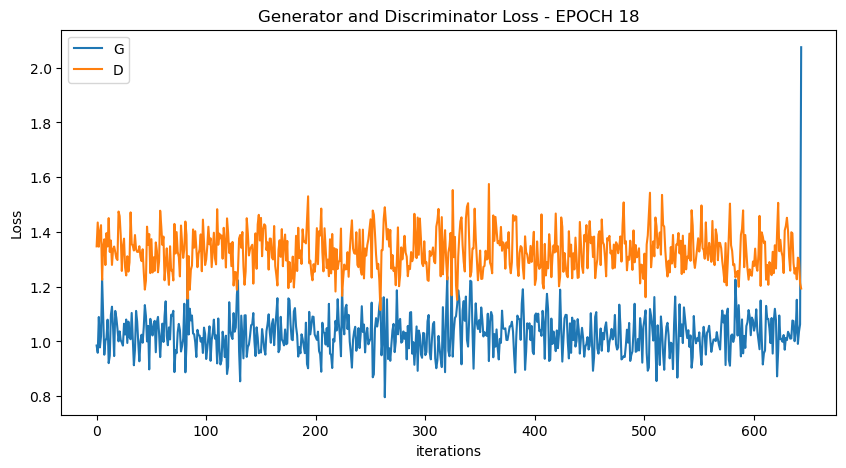

  0%|          | 0/644 [00:00<?, ?it/s]

[20/100][322/644] Loss_D: 1.4090 Loss_G: 1.0834 D(x): 0.4937 D(G(z)): 0.4785 / 0.3391
[20/100][644/644] Loss_D: 1.2306 Loss_G: 2.1411 D(x): 0.5081 D(G(z)): 0.3813 / 0.0962


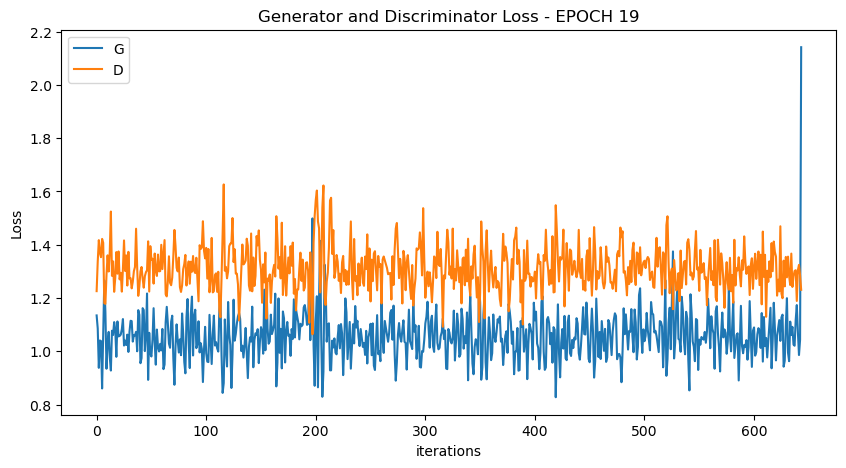

  0%|          | 0/644 [00:00<?, ?it/s]

[21/100][322/644] Loss_D: 1.4246 Loss_G: 0.9505 D(x): 0.4262 D(G(z)): 0.4209 / 0.3785
[21/100][644/644] Loss_D: 1.0659 Loss_G: 2.9051 D(x): 0.6526 D(G(z)): 0.4269 / 0.0463


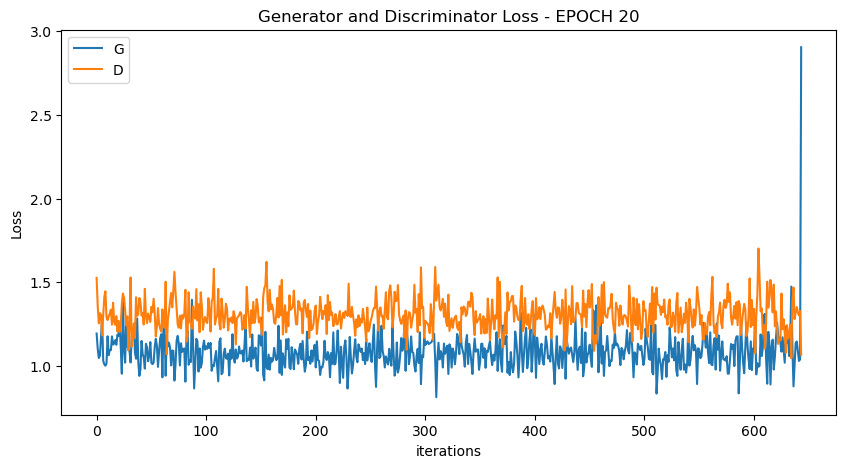

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


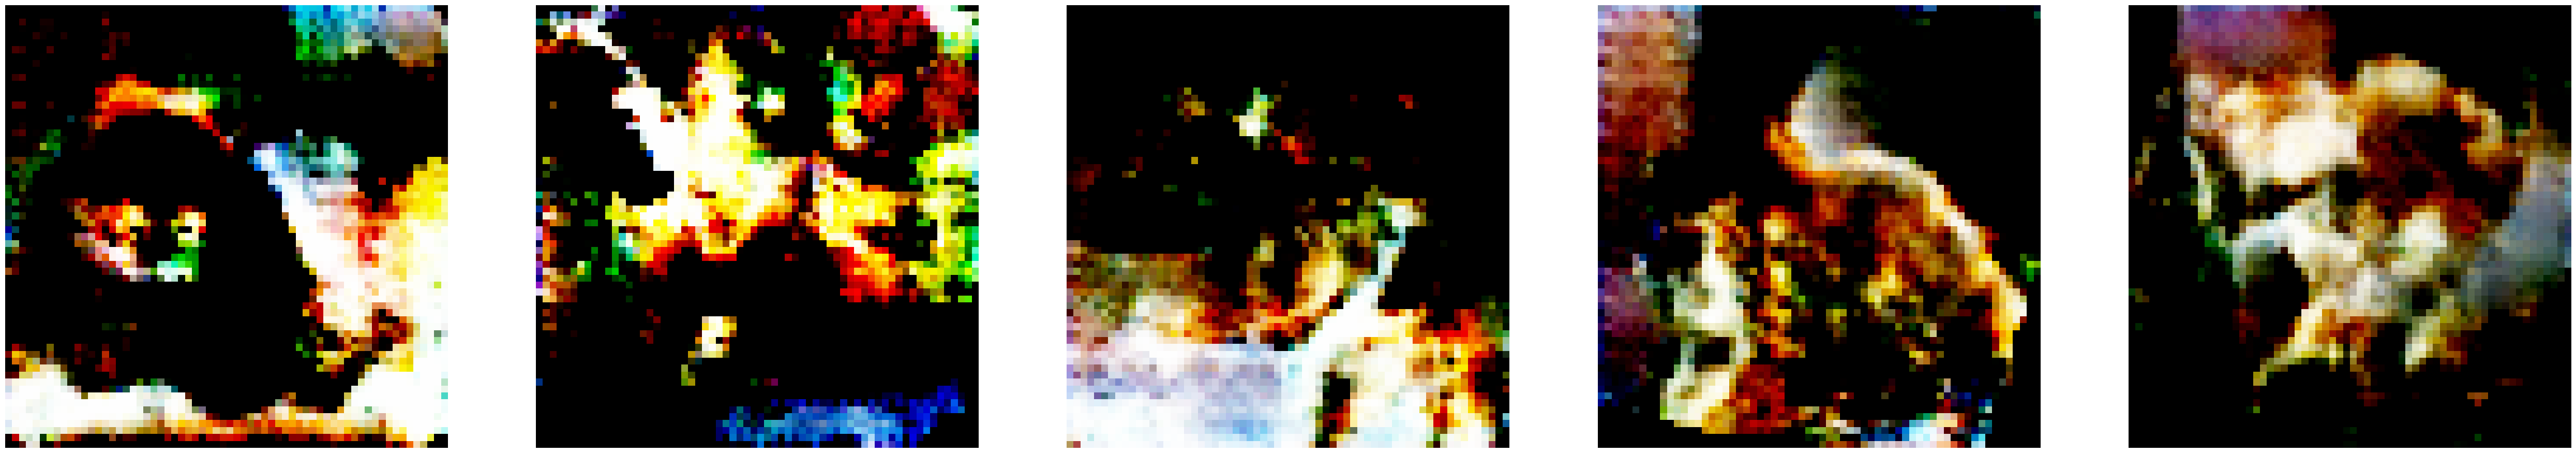

  0%|          | 0/644 [00:00<?, ?it/s]

[22/100][322/644] Loss_D: 1.3303 Loss_G: 1.0496 D(x): 0.4658 D(G(z)): 0.4030 / 0.3420
[22/100][644/644] Loss_D: 1.1684 Loss_G: 2.4488 D(x): 0.5464 D(G(z)): 0.3847 / 0.0939


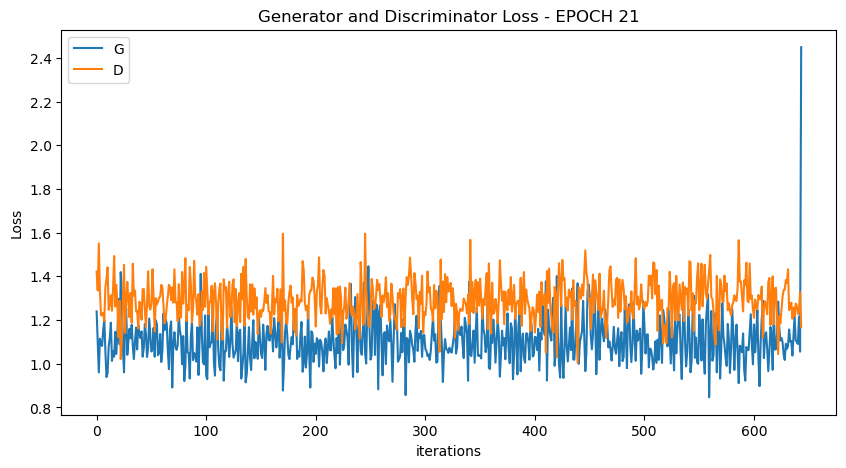

  0%|          | 0/644 [00:00<?, ?it/s]

[23/100][322/644] Loss_D: 1.1519 Loss_G: 1.1614 D(x): 0.4770 D(G(z)): 0.3055 / 0.3045
[23/100][644/644] Loss_D: 1.5575 Loss_G: 1.4874 D(x): 0.2694 D(G(z)): 0.2775 / 0.2097


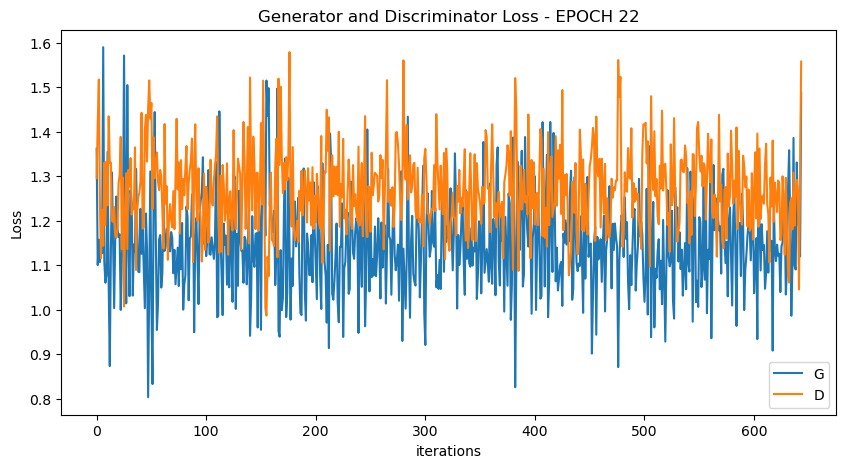

  0%|          | 0/644 [00:00<?, ?it/s]

[24/100][322/644] Loss_D: 1.0791 Loss_G: 1.3026 D(x): 0.5961 D(G(z)): 0.3764 / 0.2531
[24/100][644/644] Loss_D: 1.4401 Loss_G: 2.0661 D(x): 0.3067 D(G(z)): 0.2746 / 0.1050


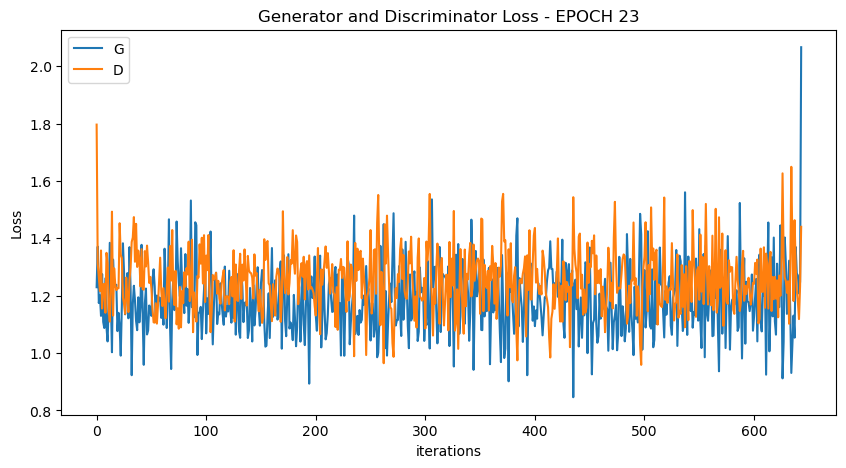

  0%|          | 0/644 [00:00<?, ?it/s]

[25/100][322/644] Loss_D: 1.4816 Loss_G: 1.1680 D(x): 0.5896 D(G(z)): 0.5594 / 0.3047
[25/100][644/644] Loss_D: 1.5404 Loss_G: 2.6822 D(x): 0.4087 D(G(z)): 0.4819 / 0.0843


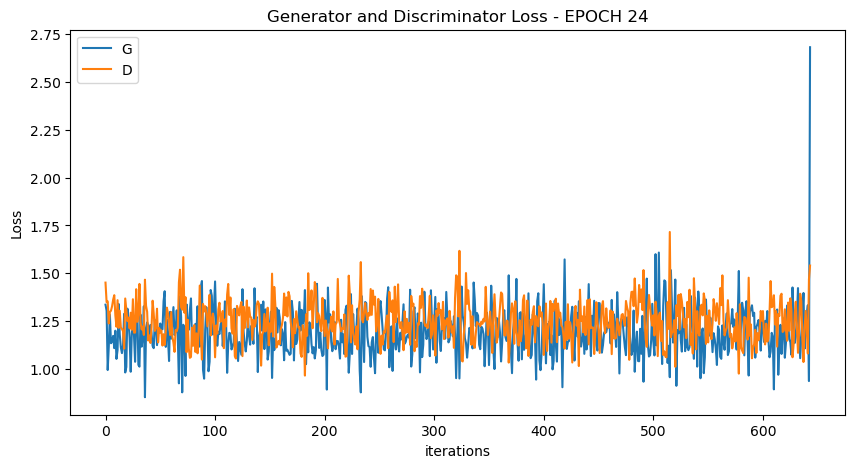

  0%|          | 0/644 [00:00<?, ?it/s]

[26/100][322/644] Loss_D: 1.3973 Loss_G: 1.0799 D(x): 0.4025 D(G(z)): 0.3473 / 0.3399
[26/100][644/644] Loss_D: 0.9225 Loss_G: 2.7548 D(x): 0.5357 D(G(z)): 0.2434 / 0.0480


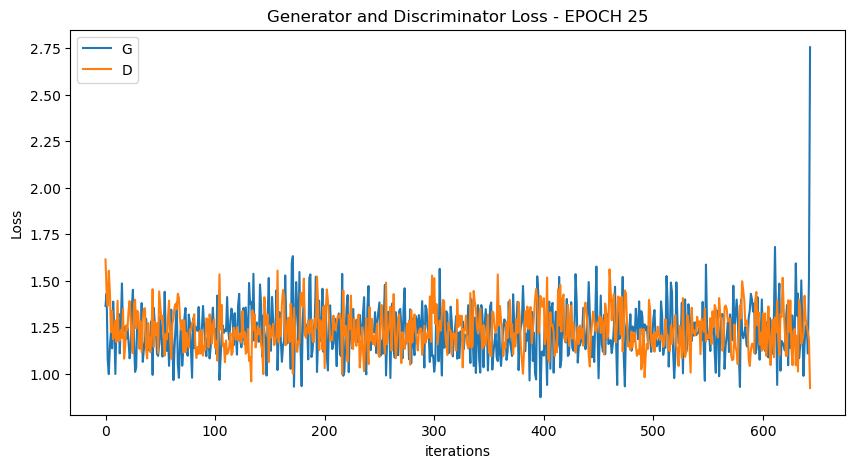

  0%|          | 0/644 [00:00<?, ?it/s]

[27/100][322/644] Loss_D: 1.1953 Loss_G: 1.2461 D(x): 0.5981 D(G(z)): 0.4453 / 0.2723
[27/100][644/644] Loss_D: 2.1832 Loss_G: 2.9211 D(x): 0.2799 D(G(z)): 0.5552 / 0.0430


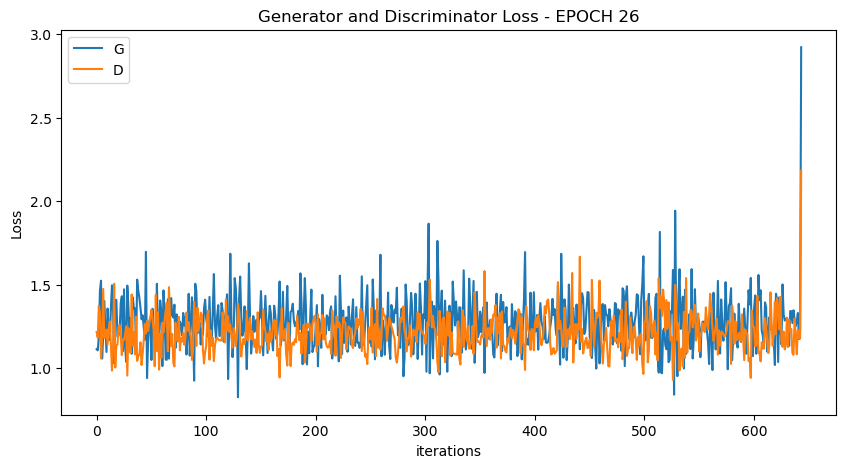

  0%|          | 0/644 [00:00<?, ?it/s]

[28/100][322/644] Loss_D: 1.1694 Loss_G: 1.3034 D(x): 0.5989 D(G(z)): 0.4118 / 0.2662
[28/100][644/644] Loss_D: 0.8873 Loss_G: 2.3057 D(x): 0.5237 D(G(z)): 0.1168 / 0.0851


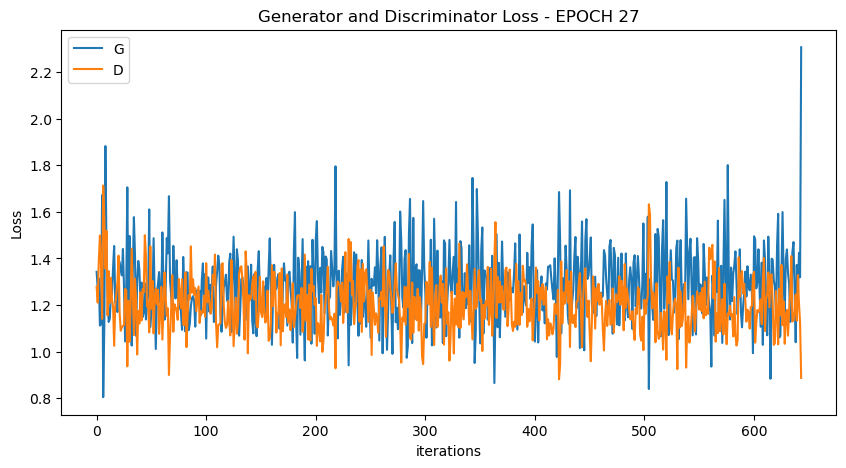

  0%|          | 0/644 [00:00<?, ?it/s]

[29/100][322/644] Loss_D: 1.1176 Loss_G: 1.4940 D(x): 0.5845 D(G(z)): 0.3683 / 0.2211
[29/100][644/644] Loss_D: 0.8962 Loss_G: 2.5709 D(x): 0.5021 D(G(z)): 0.1731 / 0.0583


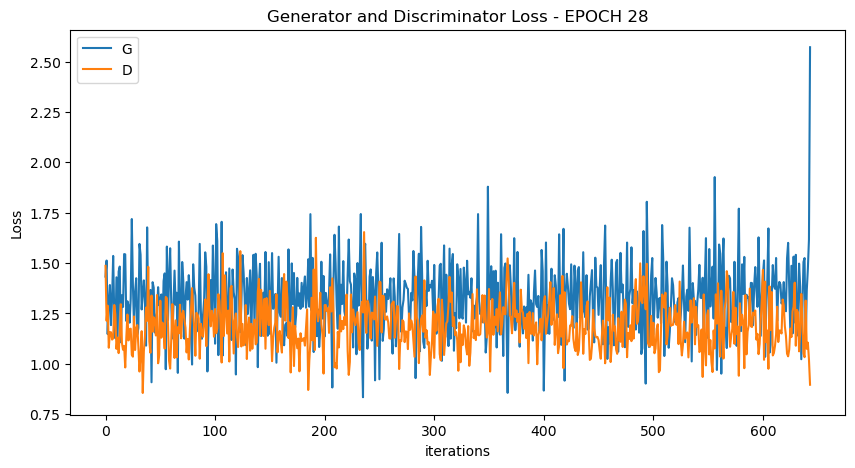

  0%|          | 0/644 [00:00<?, ?it/s]

[30/100][322/644] Loss_D: 1.2344 Loss_G: 1.1780 D(x): 0.4143 D(G(z)): 0.2748 / 0.3096
[30/100][644/644] Loss_D: 1.5879 Loss_G: 4.4926 D(x): 0.5348 D(G(z)): 0.5288 / 0.0109


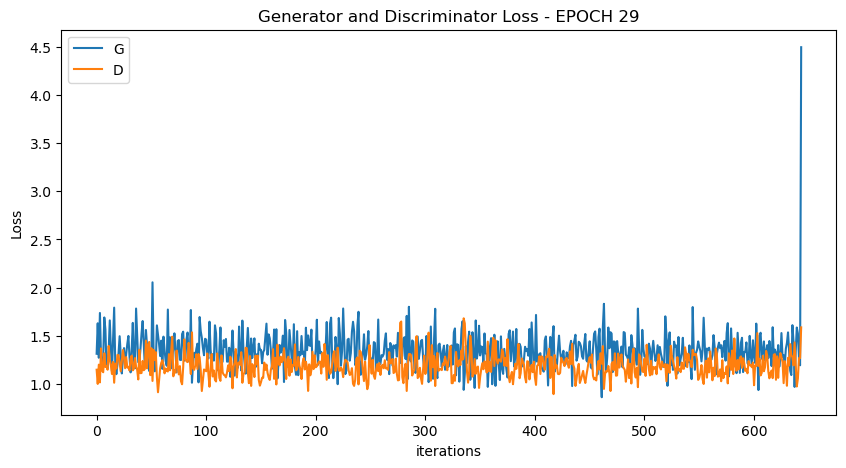

  0%|          | 0/644 [00:00<?, ?it/s]

[31/100][322/644] Loss_D: 1.1427 Loss_G: 1.1907 D(x): 0.5740 D(G(z)): 0.3803 / 0.2983
[31/100][644/644] Loss_D: 1.4887 Loss_G: 3.0029 D(x): 0.3192 D(G(z)): 0.3173 / 0.0583


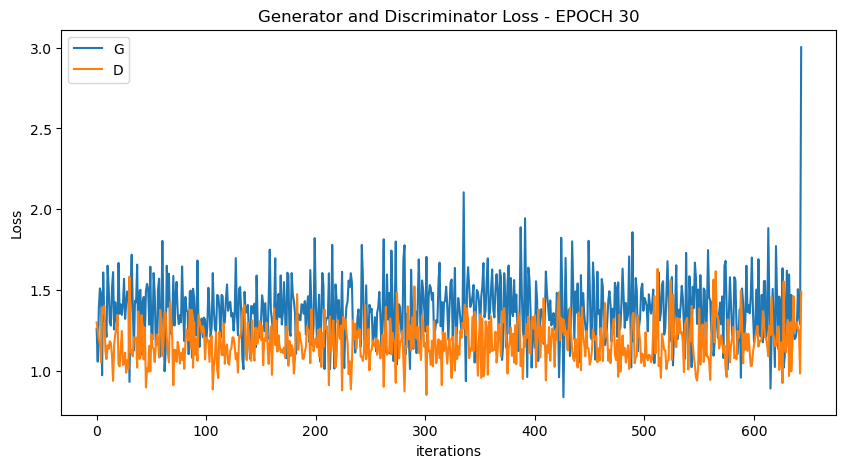

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


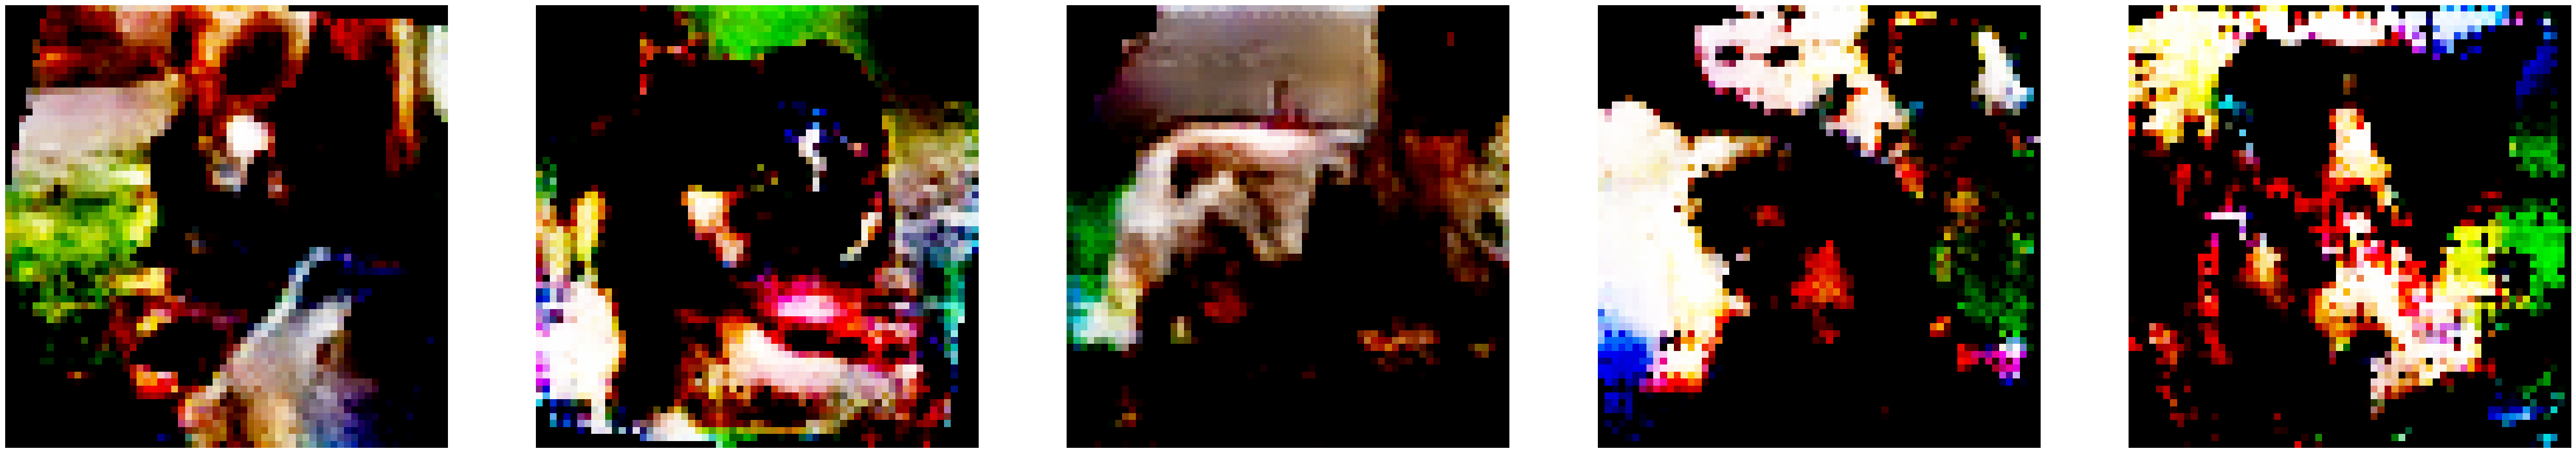

  0%|          | 0/644 [00:00<?, ?it/s]

[32/100][322/644] Loss_D: 1.0554 Loss_G: 1.5148 D(x): 0.6733 D(G(z)): 0.4022 / 0.2133
[32/100][644/644] Loss_D: 0.9281 Loss_G: 2.3659 D(x): 0.4534 D(G(z)): 0.0573 / 0.0736


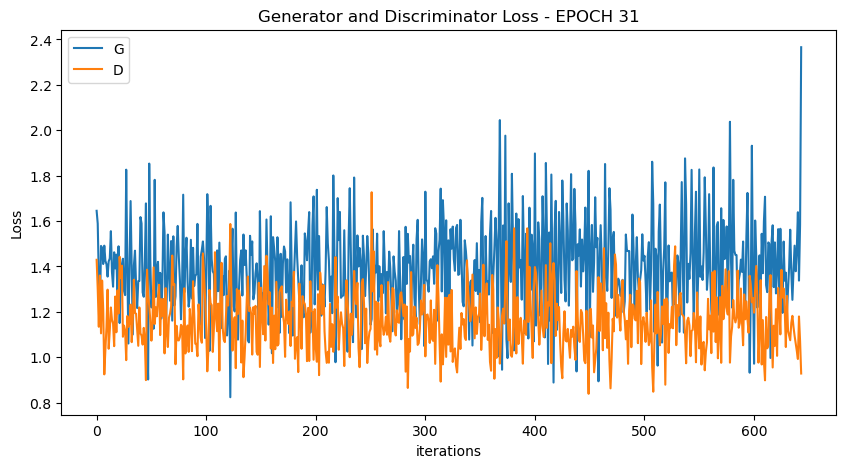

  0%|          | 0/644 [00:00<?, ?it/s]

[33/100][322/644] Loss_D: 1.1209 Loss_G: 1.1964 D(x): 0.5055 D(G(z)): 0.3088 / 0.2875
[33/100][644/644] Loss_D: 1.5731 Loss_G: 3.3770 D(x): 0.4286 D(G(z)): 0.3680 / 0.0488


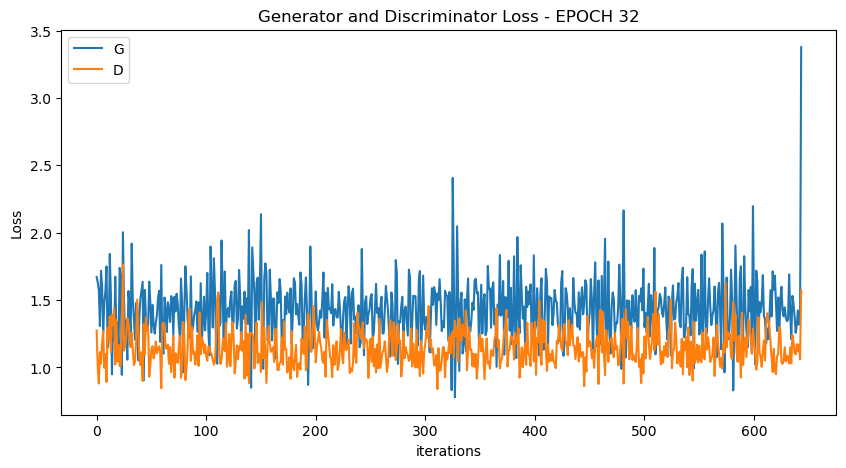

  0%|          | 0/644 [00:00<?, ?it/s]

[34/100][322/644] Loss_D: 1.1134 Loss_G: 1.3879 D(x): 0.4865 D(G(z)): 0.2722 / 0.2386
[34/100][644/644] Loss_D: 1.4987 Loss_G: 5.9690 D(x): 0.5962 D(G(z)): 0.5702 / 0.0023


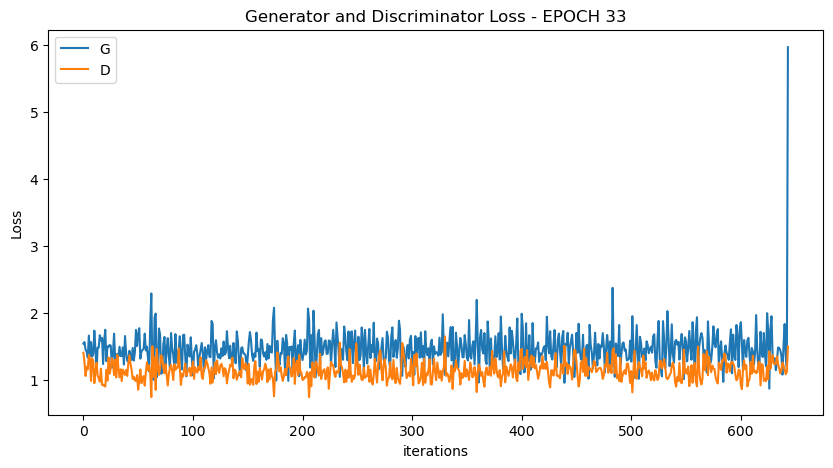

  0%|          | 0/644 [00:00<?, ?it/s]

[35/100][322/644] Loss_D: 1.1459 Loss_G: 2.1123 D(x): 0.7206 D(G(z)): 0.4707 / 0.1052
[35/100][644/644] Loss_D: 0.8713 Loss_G: 3.8590 D(x): 0.6385 D(G(z)): 0.2733 / 0.0172


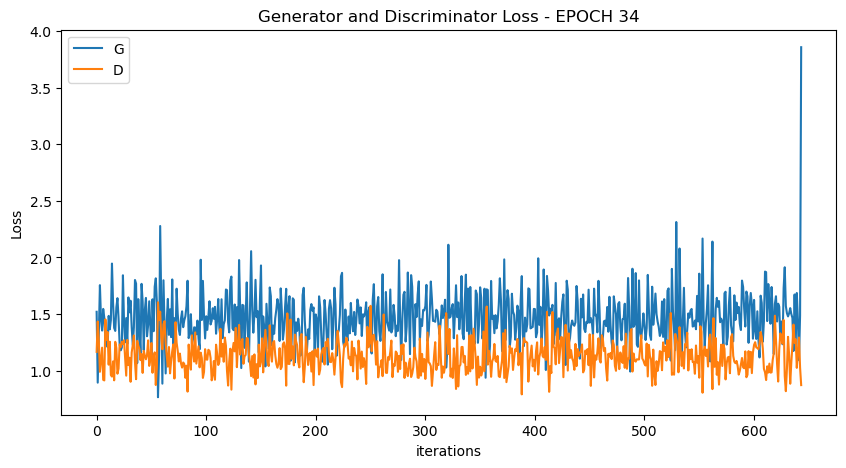

  0%|          | 0/644 [00:00<?, ?it/s]

[36/100][322/644] Loss_D: 1.0707 Loss_G: 1.4599 D(x): 0.4990 D(G(z)): 0.2525 / 0.2289
[36/100][644/644] Loss_D: 1.7544 Loss_G: 1.1886 D(x): 0.1986 D(G(z)): 0.1156 / 0.2855


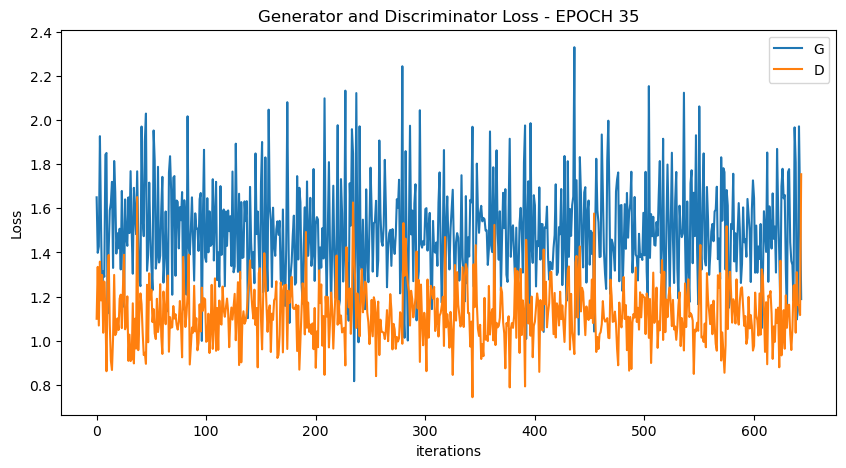

  0%|          | 0/644 [00:00<?, ?it/s]

[37/100][322/644] Loss_D: 1.2616 Loss_G: 1.4663 D(x): 0.4937 D(G(z)): 0.3454 / 0.2288
[37/100][644/644] Loss_D: 0.9619 Loss_G: 2.6535 D(x): 0.4747 D(G(z)): 0.1476 / 0.0605


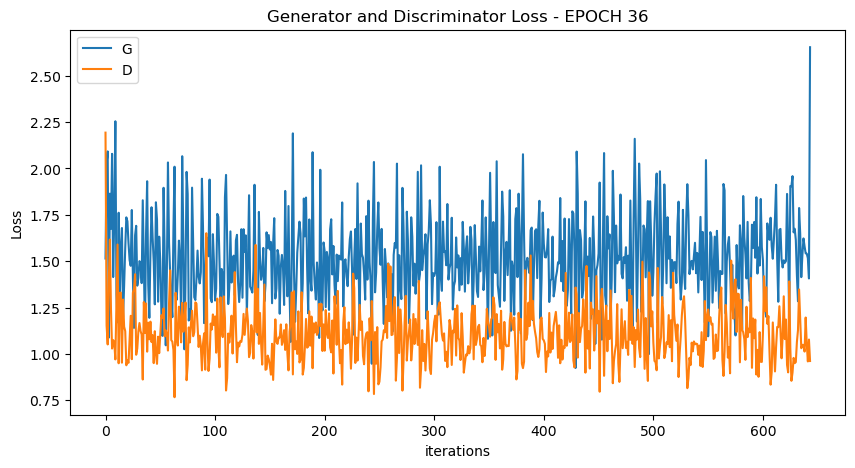

  0%|          | 0/644 [00:00<?, ?it/s]

[38/100][322/644] Loss_D: 1.2598 Loss_G: 1.3839 D(x): 0.5231 D(G(z)): 0.3859 / 0.2555
[38/100][644/644] Loss_D: 1.0736 Loss_G: 4.0198 D(x): 0.6048 D(G(z)): 0.3223 / 0.0159


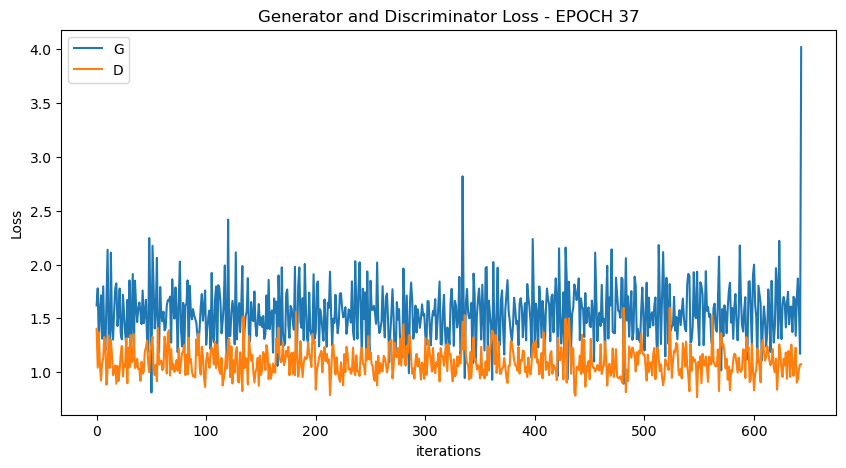

  0%|          | 0/644 [00:00<?, ?it/s]

[39/100][322/644] Loss_D: 1.0389 Loss_G: 1.3149 D(x): 0.5167 D(G(z)): 0.2325 / 0.2701
[39/100][644/644] Loss_D: 0.9340 Loss_G: 1.9750 D(x): 0.5043 D(G(z)): 0.1523 / 0.1669


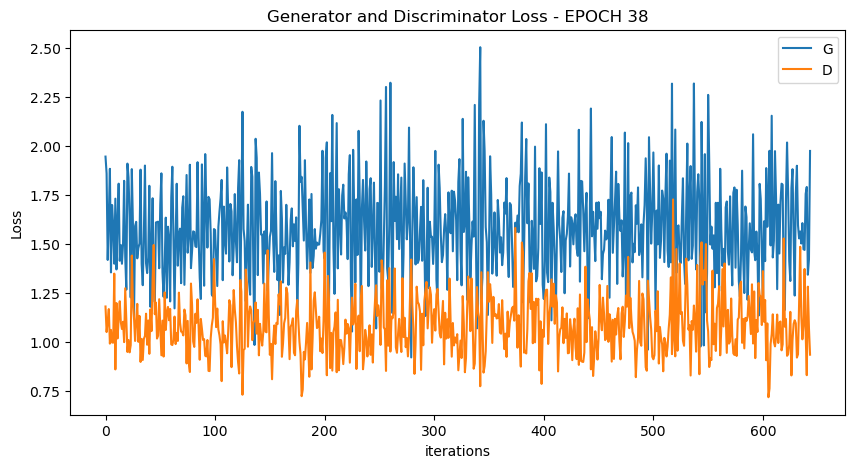

  0%|          | 0/644 [00:00<?, ?it/s]

[40/100][322/644] Loss_D: 1.0455 Loss_G: 1.9771 D(x): 0.6981 D(G(z)): 0.3893 / 0.1332
[40/100][644/644] Loss_D: 1.3030 Loss_G: 1.7312 D(x): 0.3220 D(G(z)): 0.1135 / 0.1497


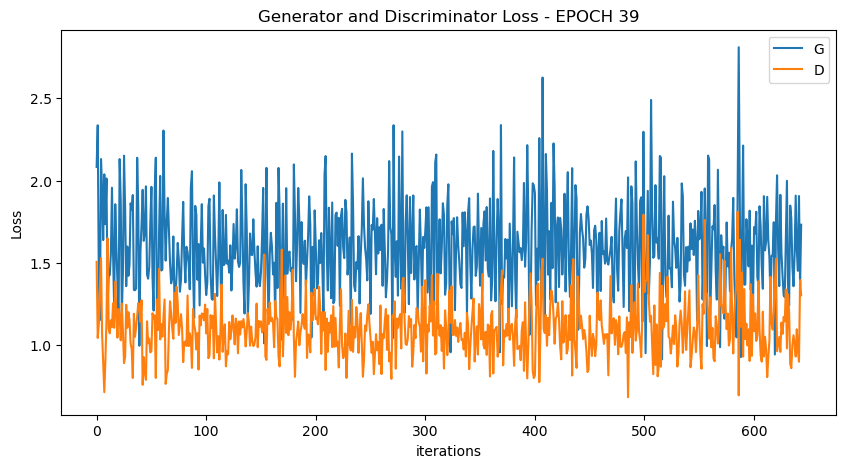

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)